In [2]:
import pandas as pd
import numpy as np
import tmap as tm
from mhfp.encoder import MHFPEncoder
from mhfp.lsh_forest import LSHForestHelper

df = pd.read_csv('../data/dataset.csv')

df = df.head(100)

perm = 512 
enc = MHFPEncoder(perm) 
fingerprints = [tm.VectorUint(enc.encode(s)) for s in df['canonical_smiles']]

lsh_forest = tm.LSHForest(d=128, l=8, store=True, file_backed=False, weighted=False)
lsh_forest.batch_add(fingerprints)
lsh_forest.index()

In [7]:
# Get k-nearest neighbors for all vectors
k = 10
kc = 10
all_neighbors = lsh_forest.get_all_nearest_neighbors(k, kc)


In [8]:
# Get the KNN graph
from_nodes = tm.VectorUint()
to_nodes = tm.VectorUint()
weights = tm.VectorFloat()
lsh_forest.get_knn_graph(from_nodes, to_nodes, weights, k, kc)

In [9]:
# Convert to numpy arrays if needed
from_array = np.array(from_nodes)
to_array = np.array(to_nodes)
weight_array = np.array(weights)

In [33]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor(np.array([from_array, to_array]), dtype=torch.long)
edge_attr = torch.tensor(np.array(weight_array)[:, np.newaxis], dtype=torch.float)

num_nodes = max(from_array.max(), to_array.max()) + 1
node_features = torch.randn(num_nodes, 64)  # Example: 64-dimensional random features

graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

## Using NetworkX and Matplotlib for visualization

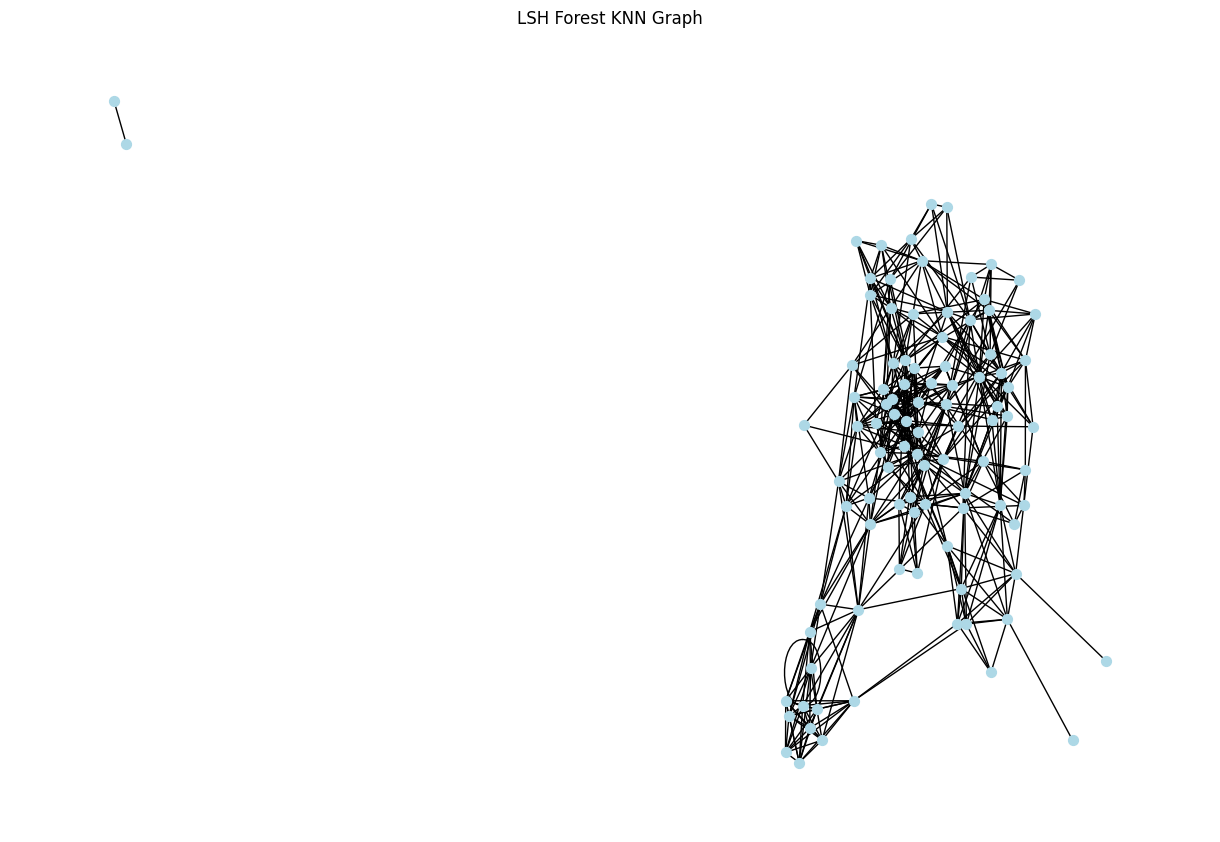

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert your PyTorch Geometric graph to a NetworkX graph
G = nx.Graph()
edge_index = graph.edge_index.numpy()
for i in range(edge_index.shape[1]):
    G.add_edge(edge_index[0, i], edge_index[1, i])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # This computes a layout for the graph
nx.draw(G, pos, node_size=50, node_color='lightblue', with_labels=False)
plt.title("LSH Forest KNN Graph")
plt.show()

## Using Plotly for Visualization

In [29]:
import plotly.graph_objects as go
import networkx as nx

# Convert to NetworkX graph as before
G = nx.Graph()
edge_index = graph.edge_index.numpy()
for i in range(edge_index.shape[1]):
    G.add_edge(edge_index[0, i], edge_index[1, i])

# Get node positions
pos = nx.spring_layout(G, dim=3)

# Create edges
edge_x = []
edge_y = []
edge_z = []
for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

# Create nodes
node_x, node_y, node_z = zip(*pos.values())

# Create the graph
fig = go.Figure(data=[
    go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', line=dict(color='gray', width=1), hoverinfo='none'),
    go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers', marker=dict(size=5, color='lightblue'), hoverinfo='text')
])

fig.update_layout(title='LSH Forest KNN Graph', showlegend=False, scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
fig.show()

In [1]:
import pandas as pd
import numpy as np
import tmap as tm
from mhfp.encoder import MHFPEncoder
import torch
from torch_geometric.data import Data
import networkx as nx
import plotly.graph_objects as go
from rdkit import Chem
from rdkit.Chem import Descriptors

# Error handling for file reading
try:
    df = pd.read_csv('../data/dataset.csv')
except FileNotFoundError:
    print("Dataset file not found. Please check the file path.")
    exit()

# Take first 100 rows for demonstration
df = df.head(100)

perm = 512 
enc = MHFPEncoder(perm) 

# Error handling for SMILES encoding
fingerprints = []
valid_smiles = []
for s in df['canonical_smiles']:
    try:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            fp = tm.VectorUint(enc.encode(s))
            fingerprints.append(fp)
            valid_smiles.append(s)
    except:
        print(f"Error encoding SMILES: {s}")

num_nodes = len(valid_smiles)
print(f"Number of valid molecules: {num_nodes}")

lsh_forest = tm.LSHForest(d=128, l=8, store=True, file_backed=False, weighted=False)
lsh_forest.batch_add(fingerprints)
lsh_forest.index()

# Get the KNN graph
from_nodes = tm.VectorUint()
to_nodes = tm.VectorUint()
weights = tm.VectorFloat()
k = 10
kc = 10
lsh_forest.get_knn_graph(from_nodes, to_nodes, weights, k, kc)

# Convert to numpy arrays
from_array = np.array(from_nodes)
to_array = np.array(to_nodes)
weight_array = np.array(weights)

# Create PyTorch Geometric graph
edge_index = torch.tensor(np.array([from_array, to_array]), dtype=torch.long)
edge_attr = torch.tensor(weight_array[:, np.newaxis], dtype=torch.float)

# Use the number of valid SMILES for node features
node_features = torch.randn(num_nodes, 64)  # Example: 64-dimensional random features

# Create the graph with node attributes
graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, smiles=valid_smiles)

# Convert to NetworkX graph for visualization
G = nx.Graph()
for i in range(num_nodes):
    G.add_node(i)
for i in range(edge_index.shape[1]):
    if edge_index[0, i] < num_nodes and edge_index[1, i] < num_nodes:
        G.add_edge(int(edge_index[0, i]), int(edge_index[1, i]))

# Add SMILES and other properties as node attributes
for i, smiles in enumerate(valid_smiles):
    mol = Chem.MolFromSmiles(smiles)
    G.nodes[i]['smiles'] = smiles
    G.nodes[i]['mol_weight'] = Descriptors.ExactMolWt(mol)

# Visualize with Plotly
pos = nx.spring_layout(G, dim=3)

edge_x, edge_y, edge_z = [], [], []
for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

node_x, node_y, node_z = zip(*pos.values())

# Create hover text with SMILES and molecular weight
hover_text = [f"Node {i}<br>SMILES: {G.nodes[i]['smiles']}<br>Mol Weight: {G.nodes[i]['mol_weight']:.2f}" for i in G.nodes()]

# Color nodes based on molecular weight
node_color = [G.nodes[i]['mol_weight'] for i in G.nodes()]

fig = go.Figure(data=[
    go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', line=dict(color='gray', width=1), hoverinfo='none'),
    go.Scatter3d(x=node_x, y=node_y, z=node_z, mode='markers', 
                 marker=dict(size=5, color=node_color, colorscale='Viridis', colorbar=dict(title='Molecular Weight')), 
                 text=hover_text, hoverinfo='text')
])

fig.update_layout(title='LSH Forest KNN Graph with SMILES', showlegend=False, 
                  scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
fig.show()

print("Graph visualization complete.")

c:\Users\biolab\miniforge3\envs\tmap\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of valid molecules: 100


Graph visualization complete.
